In [1]:
import sys
from pathlib import Path

# Ruta raíz del repo
REPO_ROOT = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored")
SRC = REPO_ROOT / "src"

if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

print("SRC en sys.path:", SRC in map(Path, sys.path))

SRC en sys.path: True


In [2]:
from pathlib import Path
from whoscored_viz import paths

# Donde están los partidos (carpeta MatchCenter)
paths.BASE_DIR = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter")

# Donde están los escudos de LaLiga
paths.ESCUDOS_DIR = Path(r"C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\Escudos\LaLiga")

# Salida de diccionarios (si quieres otra, cámbiala aquí)
paths.OUT_DIR = REPO_ROOT / r"data\dictionaries"
paths.OUT_DIR.mkdir(parents=True, exist_ok=True)

print("[BASE_DIR]", paths.BASE_DIR, "| exists:", paths.BASE_DIR.exists())
print("[ESCUDOS_DIR]", paths.ESCUDOS_DIR, "| exists:", paths.ESCUDOS_DIR.exists())
print("[OUT_DIR]", paths.OUT_DIR)

print("[TEAM_CSV]", paths.TEAM_CSV)
print("[PLAYERS_CSV]", paths.PLAYERS_CSV)

[paths.py] PROJECT_ROOT: c:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored
[paths.py] BASE_DATA_DIR: C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data
[BASE_DIR] C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter | exists: True
[ESCUDOS_DIR] C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\assets\Escudos\LaLiga | exists: True
[OUT_DIR] C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\dictionaries
[TEAM_CSV] C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\dictionaries\team_identity.csv
[PLAYERS_CSV] C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\dictionaries\players_master.csv


In [3]:
# ¿Cuántos partidos detecta?
found_meta = list(paths.BASE_DIR.rglob("csv/match_meta.csv"))
found_players = list(paths.BASE_DIR.rglob("csv/players.csv"))
print("match_meta.csv encontrados:", len(found_meta))
print("players.csv encontrados:", len(found_players))
for p in found_meta[:5]:
    print(" -", p)

match_meta.csv encontrados: 31
players.csv encontrados: 31
 - C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250815_Girona_vs_Rayo_Vallecano_1913916\csv\match_meta.csv
 - C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250815_Villarreal_vs_Real_Oviedo_1913892\csv\match_meta.csv
 - C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250816_Deportivo_Alaves_vs_Levante_1913913\csv\match_meta.csv
 - C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250816_Mallorca_vs_Barcelona_1913918\csv\match_meta.csv
 - C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\raw\matchcenter\MatchCenter\Competition\Season\20250816_Valencia_vs_Real_Sociedad_1913889\csv\match_meta.csv


In [4]:
import pandas as pd
from whoscored_viz import dictionaries
from whoscored_viz.utils_io import read_csv_safe

# --- Fallback local solo notebook (por si tu build_team_dictionary oficial falla).
# Lee directamente todos los match_meta.csv con tus helpers (slug, resolve_logo_path, colors).
def build_team_dictionary_notebook(max_matches: int = 50) -> pd.DataFrame:
    rows = []
    from whoscored_viz.dictionaries import slug_from_teamname, resolve_logo_path, TEAM_COLORS_BY_ID
    metas = list(paths.BASE_DIR.rglob("csv/match_meta.csv"))[:max_matches]
    for meta_csv in metas:
        mm = read_csv_safe(meta_csv)
        if mm is None or mm.empty:
            continue
        cols = {c.strip().lower(): c for c in mm.columns}
        def col(*names):
            for n in names:
                if n in cols:
                    return cols[n]
        hid = col("home_team_id","home_id","hometeamid")
        hnm = col("home_name","home_team_name","hometeamname","home")
        aid = col("away_team_id","away_id","awayteamid")
        anm = col("away_name","away_team_name","awayteamname","away")
        if not all([hid, hnm, aid, anm]):
            continue
        for tid, tnm in [
            (int(mm.iloc[0][hid]), str(mm.iloc[0][hnm])),
            (int(mm.iloc[0][aid]), str(mm.iloc[0][anm])),
        ]:
            slug = slug_from_teamname(tnm)
            colors = TEAM_COLORS_BY_ID.get(tid, {})
            rows.append({
                "team_id":  tid,
                "team_name": tnm,
                "slug": slug,
                "logo_path": dictionaries.resolve_logo_path(slug) or "",
                "primary":  colors.get("primary",""),
                "secondary":colors.get("secondary",""),
            })
    df = (pd.DataFrame(rows)
            .drop_duplicates("team_id")
            .sort_values("team_id")
            .reset_index(drop=True))
    df.to_csv(paths.TEAM_CSV, index=False, encoding="utf-8")
    return df

# --- Ejecutar: primero intentamos el builder oficial; si da error, usamos el fallback ---
try:
    teams_df = dictionaries.build_team_dictionary(max_matches=50)
    print("[OK] build_team_dictionary (módulo) ejecutado.")
except Exception as e:
    print("[WARN] builder oficial falló → uso fallback notebook.", e)
    teams_df = build_team_dictionary_notebook(max_matches=50)

print(f"Equipos únicos: {teams_df.team_id.nunique()}  → {paths.TEAM_CSV}")
teams_df.head(10)

[WARN] builder oficial falló → uso fallback notebook. No se pudieron extraer equipos de CSV/JSON.
Equipos únicos: 20  → C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\dictionaries\team_identity.csv


,team_id,team_name,slug,logo_path,primary,secondary
0,51,Mallorca,mallorca,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#D00000,#1A1A1A
1,52,Real Madrid,realmadrid,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#FFFFFF,#1D1D1B
2,53,Athletic Club,athletic,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#D00027,#1A1A1A
3,54,Real Betis,betis,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#009E49,#FFFFFF
4,55,Valencia,valencia,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#FF7900,#000000
5,60,Deportivo Alaves,alaves,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#003DA5,#FFFFFF
6,61,Real Oviedo,realoviedo,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#0057B8,#FFD100
7,62,Celta Vigo,celta,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#8EC6E8,#E30613
8,63,Atletico,atlmadrid,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#D20A11,#1B3D8E
9,64,Rayo Vallecano,rayovallecano,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#E30613,#FFFFFF


In [5]:
import numpy as np

def build_players_dictionary_notebook() -> pd.DataFrame:
    rows = []
    for p in paths.BASE_DIR.rglob("csv/players.csv"):
        try:
            df = pd.read_csv(p)
        except Exception:
            continue
        if df is None or df.empty:
            continue

        cols = {c.strip().lower(): c for c in df.columns}
        def col(*names):
            for n in names:
                if n in cols:
                    return cols[n]

        pid   = col("player_id","playerid","id")
        pname = col("player_name","name","player")
        tid   = col("team_id","teamid")
        tname = col("team_name","team")
        shirt = col("shirtnumber","shirtno","number","no")

        if not (pid and pname):
            continue

        tmp = pd.DataFrame({
            "player_id": pd.to_numeric(df[pid], errors="coerce").astype("Int64"),
            "player_name": df[pname].astype(str),
            "team_id": pd.to_numeric(df[tid], errors="coerce").astype("Int64") if tid else pd.Series([pd.NA]*len(df), dtype="Int64"),
            "team_name": df[tname].astype(str) if tname else "",
            "shirtNo": pd.to_numeric(df[shirt], errors="coerce").astype("Int64") if shirt else pd.Series([pd.NA]*len(df), dtype="Int64"),
        })
        rows.append(tmp)

    if not rows:
        out = pd.DataFrame(columns=["player_id","player_name","team_id","team_name","shirtNo"])
    else:
        out = pd.concat(rows, ignore_index=True)
        out = out.dropna(subset=["player_id"])
        out["player_id"] = out["player_id"].astype(int)
        out["name_len"] = out["player_name"].str.len()
        out = (out.sort_values(["player_id","name_len"], ascending=[True, False])
                 .drop_duplicates("player_id", keep="first")
                 .drop(columns=["name_len"])
                 .reset_index(drop=True))

    out.to_csv(paths.PLAYERS_CSV, index=False, encoding="utf-8")
    return out

try:
    players_df = build_players_dictionary_notebook()
    print(f"Jugadores únicos: {players_df.shape[0]}  → {paths.PLAYERS_CSV}")
    players_df.head(10)
except Exception as e:
    print("[WARN] No se pudo construir players_master.csv:", e)

Jugadores únicos: 507  → C:\Users\manue\OneDrive\Escritorio\Proyecto WhoScored\data\dictionaries\players_master.csv


In [6]:
from whoscored_viz import identity

# Toma algunos equipos y comprueba que identity devuelve {primary, secondary, logo, ...}
check = []
for tid, tnm in teams_df[["team_id","team_name"]].head(8).itertuples(index=False):
    s = identity.team_style(int(tid), fallback_name=str(tnm))
    check.append({"team_id": tid, "name": tnm, "primary": s.get("primary"), "secondary": s.get("secondary"), "logo": s.get("logo")})

pd.DataFrame(check)

,team_id,name,primary,secondary,logo
0,51,Mallorca,#D00000,#1A1A1A,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
1,52,Real Madrid,#FFFFFF,#1D1D1B,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
2,53,Athletic Club,#D00027,#1A1A1A,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
3,54,Real Betis,#009E49,#FFFFFF,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
4,55,Valencia,#FF7900,#000000,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
5,60,Deportivo Alaves,#003DA5,#FFFFFF,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
6,61,Real Oviedo,#0057B8,#FFD100,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...
7,62,Celta Vigo,#8EC6E8,#E30613,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...


In [7]:
t = pd.read_csv(paths.TEAM_CSV)
missing = (t["logo_path"].fillna("")=="").sum()
print(f"Escudos encontrados: {len(t)-missing} / {len(t)}")
if missing:
    print("Revisa SLUG_ALIASES en dictionaries.py o los nombres de archivo en", paths.ESCUDOS_DIR)
t.head(10)

Escudos encontrados: 20 / 20


,team_id,team_name,slug,logo_path,primary,secondary
0,51,Mallorca,mallorca,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#D00000,#1A1A1A
1,52,Real Madrid,realmadrid,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#FFFFFF,#1D1D1B
2,53,Athletic Club,athletic,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#D00027,#1A1A1A
3,54,Real Betis,betis,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#009E49,#FFFFFF
4,55,Valencia,valencia,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#FF7900,#000000
5,60,Deportivo Alaves,alaves,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#003DA5,#FFFFFF
6,61,Real Oviedo,realoviedo,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#0057B8,#FFD100
7,62,Celta Vigo,celta,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#8EC6E8,#E30613
8,63,Atletico,atlmadrid,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#D20A11,#1B3D8E
9,64,Rayo Vallecano,rayovallecano,C:\Users\manue\OneDrive\Escritorio\Proyecto Wh...,#E30613,#FFFFFF


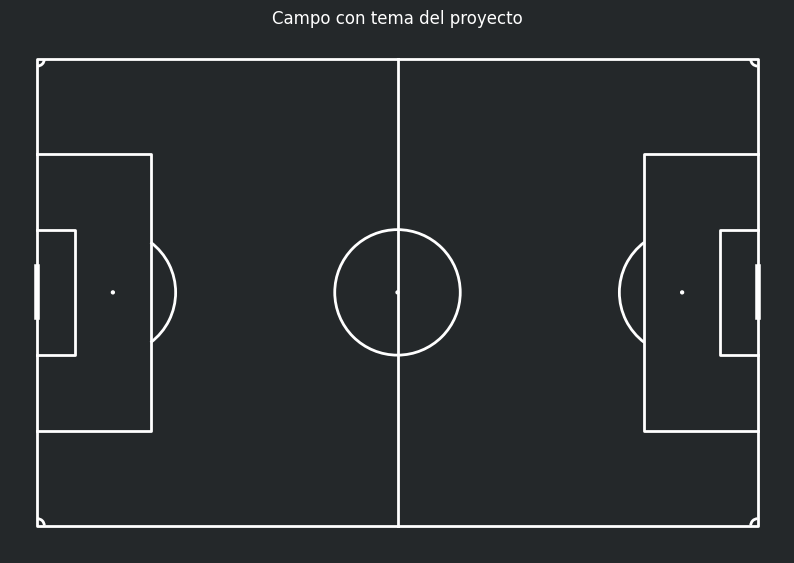

In [8]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

BG_COLOR   = "#24282a"
LINE_COLOR = "white"

def make_pitch(figsize=(10,7)):
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor(BG_COLOR)
    ax.patch.set_facecolor(BG_COLOR)
    pitch = Pitch(pitch_type="uefa", corner_arcs=True,
                  pitch_color=BG_COLOR, line_color=LINE_COLOR,
                  linewidth=2, stripe=False)
    pitch.draw(ax=ax)
    return fig, ax, pitch

_, ax, _ = make_pitch()
ax.set_title("Campo con tema del proyecto", color="white")
plt.show()